# ***CIFAR-10 Dataset: Multiclass Classifier***

## ***Import Libraries***

In [22]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, MaxPool2D, UpSampling2D, Input
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
from tensorflow.keras.applications.resnet50 import ResNet50
%matplotlib inline

## ***Parameters***

In [12]:
batch_size = 32
# CIFAR-10 Classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## ***Plotting Functions***

In [13]:
# Set plot parameters
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# Display Images
def display_images(images, predictions, labels, title):
    n = 10 # 10 Images to be displayed
    indexes = np.random.choice(len(predictions), size = n)  # Generate 10 random indexes from (0 to number of images)
    n_images = images[indexes]   # Fetch images from the provided data
    n_predictions = predictions[indexes]   # Labels at the indexes
    n_predictions = n_predictions.reshape((n,))
    n_labels = labels[indexes] # Fetches labels
    
    fig = plt.figure(figsize= (20,2)) # Total size of all images displayed outer box
    plt.title(title)
    # Remove the axis numbers
    plt.yticks([])
    plt.xticks([])
    
        
    for i in range(10):
        # add_subplot:  (nrows, ncols, index)
        # Here its 1 row and 10 columns
        ax = fig.add_subplot(1, 10, i+1)
        class_index = n_predictions[i] # Get class name
        plt.xlabel(classes[class_index])
        plt.yticks([])
        plt.xticks([])
        plt.imshow(n_images[i])

## ***Load and preprocess dataset***

In [14]:
(training_images, training_labels), (validation_images, validation_labels) = cifar10.load_data()

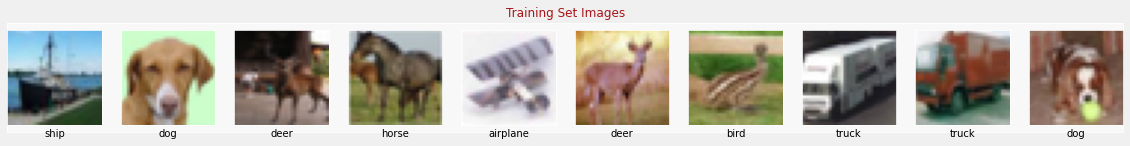

In [15]:
# Display Images

display_images(training_images, training_labels, training_labels, "Training Set Images")

## ***Preprocessing: ResNet 50 function***
#### ResNet 50 has a built-in function for preprocessing the images that would be fed into the model

In [16]:
def preprocess_images(input_images):
    images = input_images.astype('float32')
    images = tf.keras.applications.resnet50.preprocess_input(images)
    return images

train_x = preprocess_images(training_images)
validation_x = preprocess_images(validation_images)

# ***Model creation using functions***

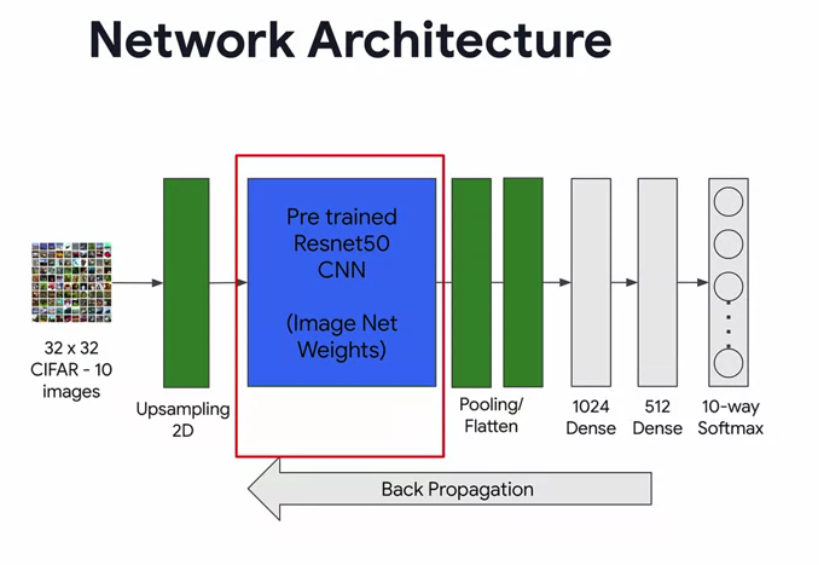

In [17]:
# Base ResNet 50 Model
def create_base_model(inputs):
    base_model = ResNet50(include_top= False,
                          weights='imagenet',
                          input_shape=(224,224,3))(inputs)
    return base_model

# Add classification top above base model
def upper_layers(inputs):
    x = GlobalAveragePooling2D()(inputs)
    x = Flatten()(x)
    x = Dense(1024, activation = 'relu')(x)
    x = Dense(512, activation = 'relu')(x)
    x = Dense(10, activation = 'softmax', name = "Final_Classifier_Layer")(x)
    return x

# Assemble the full model
def assemble_model(inputs):
    resized = UpSampling2D(size=(7,7))(inputs)
    base_model = create_base_model(resized)
    output = upper_layers(base_model)
    return output

# Compile final model
def construct_final_model():
    inputs = Input(shape=(32,32,3))
    outputs = assemble_model(inputs)
    model = keras.Model(inputs = inputs, outputs = outputs)
    # Compile model
    model.compile(optimizer= 'sgd',
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
    return model

## ***Call Model instance***

In [18]:
model = construct_final_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               5248

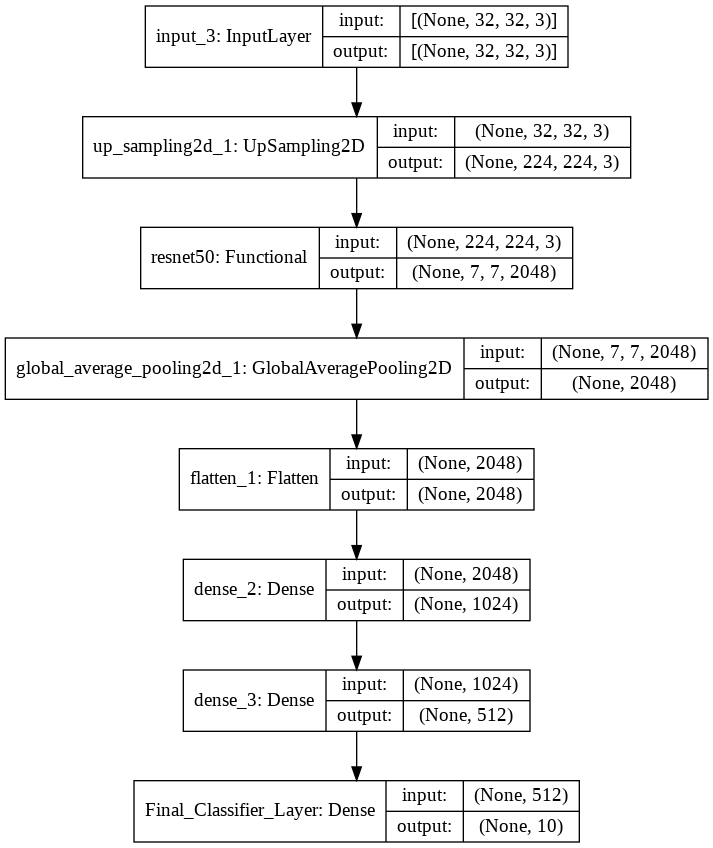

In [19]:
keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

## ***Training Model***

In [20]:
history = model.fit(train_x, training_labels, epochs=5, validation_data=(validation_x, validation_labels), verbose=1, batch_size= 64)

Epoch 1/5
782/782 [==============================] - 500s 634ms/step - loss: 0.3991 - accuracy: 0.8706 - val_loss: 0.2318 - val_accuracy: 0.9210
Epoch 2/5
782/782 [==============================] - 495s 633ms/step - loss: 0.1015 - accuracy: 0.9664 - val_loss: 0.1548 - val_accuracy: 0.9473
Epoch 3/5
782/782 [==============================] - 495s 633ms/step - loss: 0.0342 - accuracy: 0.9906 - val_loss: 0.1694 - val_accuracy: 0.9478
Epoch 4/5
782/782 [==============================] - 495s 633ms/step - loss: 0.0140 - accuracy: 0.9969 - val_loss: 0.1670 - val_accuracy: 0.9534
Epoch 5/5
782/782 [==============================] - 495s 634ms/step - loss: 0.0080 - accuracy: 0.9982 - val_loss: 0.2240 - val_accuracy: 0.9423


## ***Evaluation***

In [21]:
loss, accuracy = model.evaluate(validation_x, validation_labels)

313/313 [==============================] - 30s 92ms/step - loss: 0.2240 - accuracy: 0.9423


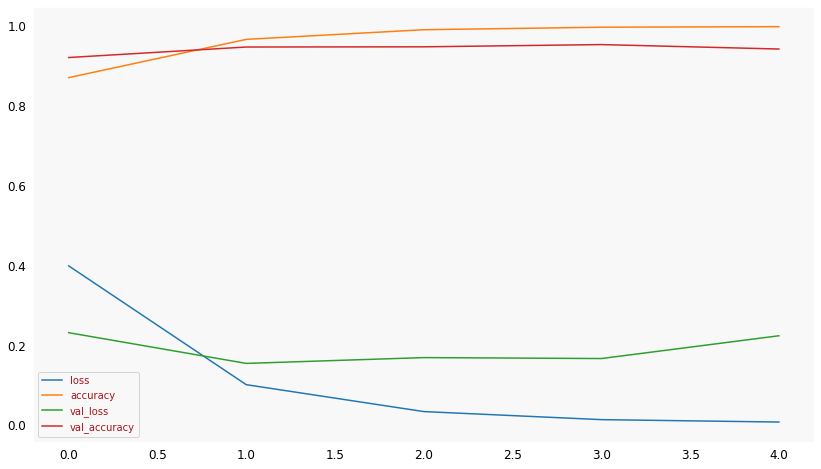

In [35]:
df = pd.DataFrame(history.history)
plt.figure(figsize= (14, 8))
plt.plot(df)
plt.legend(df.columns)
plt.show()

In [ ]:
# Save model

keras.models.save_model(model, "Cifar10.h5")

In [41]:
# model.save("cifar-10.h5")